**Armando Rios Lastiri**

# Tarea 2: Redes Convolucionales
Resuelve los siguientes ejercicios en libretas de Colab independientes que sean replicables.

### Preparación

In [ ]:
!pip install torchinfo

In [ ]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os
# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
from torch import tensor
from torch.nn.functional import mse_loss
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import pickle
import warnings
warnings.filterwarnings('ignore')

### Auxiliares

In [ ]:
def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# reproducibilidad
set_seed()

In [ ]:
DATA_DIR="data"
BATCH_SIZE=32
ROWS, COLS = 4, 8

## 1) Diseña y entrena una red convolucional para el conjunto de datos CIFAR10. Explora diferentes diseños buscando mejorar tus resultados en el ejercicio 4 de la tarea 1. Discute tus resultados.

### Datos de entrenamiento

In [ ]:
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm,
    # descaraga
    download=True
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

Files already downloaded and verified


### Datos de prueba

In [ ]:
# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=False
)

In [ ]:
#Para uso de gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        x, y_true=x.to(device), y_true.to(device)
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            x, y_true=x.to(device), y_true.to(device)
            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [ ]:
def redConvolucional(model,trn_dl, tst_dl,nombre,epocas=20):
  print(f"Model:\n{model}\n") 
  resumen=summary(model, (1, 3, 32, 32), device='cpu', verbose=0)
  print(f"\nSummary:\n{resumen}\n") 
  x = torch.zeros(1, 3, 32, 32)
  y = model(x)
  print(f'Datos sinteticos:\n{x.shape} => {y.shape}')
  # instanciamos un modelo
  model = model.to(device)
  # entrenamos
  print("\nEntrenamiento:")
  loss_hist, acc_hist = train(model, trn_dl, tst_dl,epochs=epocas)
  filename = f'{nombre}.sav'
  pickle.dump(model, open(filename, 'wb'))
  print("\nGrafica de Perdida\n")
  trn_loss, tst_loss = zip(*loss_hist)
  plt.plot(trn_loss, 'tab:orange', label='trn loss')
  plt.plot(tst_loss, 'tab:red', label='tst loss')
  plt.legend(loc='upper right')
  plt.xlabel('época')
  plt.ylabel('pérdida')
  plt.show()
  print("\nGrafica de Exactitud\n")
  trn_acc, tst_acc = zip(*acc_hist)
  plt.plot(trn_acc, 'tab:green', label='trn acc')
  plt.plot(tst_acc, 'tab:blue', label='tst acc')
  plt.legend(loc='lower right')
  plt.xlabel('época')
  plt.ylabel('exactitud')
  plt.show()
  # evaluamos en entrenamiento
  trn_loss, trn_acc = eval_epoch(trn_dl, model)
  # evaluamos en prueba
  tst_loss, tst_acc = eval_epoch(tst_dl, model)
  print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
        f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')
  print("\nEvaluacion del Modelo:\n")
  labels=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
  with torch.no_grad(): 
      x, y_true = next(iter(tst_dl))
      x, y_true=x.to(device), y_true.to(device)
      y_lgts = model(x)
      y_prob = F.softmax(y_lgts, 1)
      y_pred = torch.argmax(y_prob, 1)
      titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
      display_batch(x.cpu(), titles, ROWS, COLS)
  y_true, y_pred=y_true.cpu(), y_pred.cpu()
  print("\n",classification_report(y_true, y_pred,target_names=labels))
  print("F1-score:",round(f1_score(y_true, y_pred,average='weighted'),2))

### Modelo 1

Este modelo es el mas simple cuenta unicamente con una capa convolucional y un max pool

In [ ]:
# definición del arquitectura
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 6 * 16 * 16

        # definición de bloques conv
        self.cnn = nn.Sequential(

            # bloque conv1
            nn.Conv2d(in_channels=3, out_channels=6, 
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )       
        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

Model:
CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=1536, out_features=10, bias=True)
)


Summary:
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [1, 6, 16, 16]            --
│    └─Conv2d: 2-1                       [1, 6, 32, 32]            168
│    └─ReLU: 2-2                         [1, 6, 32, 32]            --
│    └─MaxPool2d: 2-3                    [1, 6, 16, 16]            --
├─Flatten: 1-2                           [1, 1536]                 --
├─Linear: 1-3                            [1, 10]                   15,370
Total params: 15,538
Trainable params: 15,538
Non-trainable params: 0
Total mult-adds (M): 0.18
Inp

E00 loss=[216.58,216.68] acc=[21.24,21.45]
E01 loss=[202.14,202.15] acc=[29.77,29.61]
E02 loss=[193.72,193.65] acc=[32.73,32.43]
E03 loss=[189.23,189.29] acc=[34.00,33.72]
E04 loss=[186.10,186.24] acc=[35.92,35.55]
E05 loss=[184.07,184.26] acc=[36.56,36.01]
E06 loss=[181.78,182.14] acc=[37.57,37.00]
E07 loss=[179.64,179.83] acc=[38.03,37.79]
E08 loss=[177.95,178.11] acc=[38.76,38.55]
E09 loss=[175.79,176.05] acc=[39.37,38.83]
E10 loss=[174.16,174.37] acc=[40.24,40.16]
E11 loss=[172.85,173.13] acc=[40.03,39.82]
E12 loss=[171.25,171.53] acc=[40.23,39.87]
E13 loss=[169.09,169.36] acc=[41.70,41.29]
E14 loss=[167.59,167.99] acc=[42.13,41.74]
E15 loss=[166.49,166.84] acc=[42.09,41.67]
E16 loss=[164.77,165.13] acc=[43.10,42.67]
E17 loss=[163.76,164.17] acc=[43.64,43.31]
E18 loss=[162.51,162.89] acc=[43.41,42.75]
E19 loss=[161.15,161.68] acc=[44.46,43.90]


Grafica de Perdida



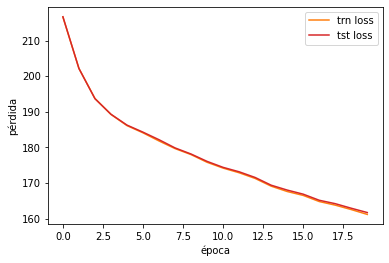


Grafica de Exactitud



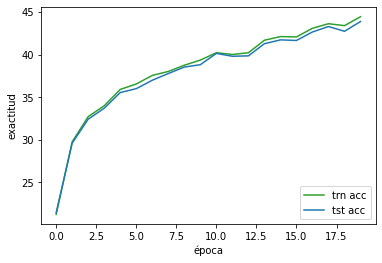

loss=[161.14,161.68] acc=[44.47,43.90]

Evaluacion del Modelo:



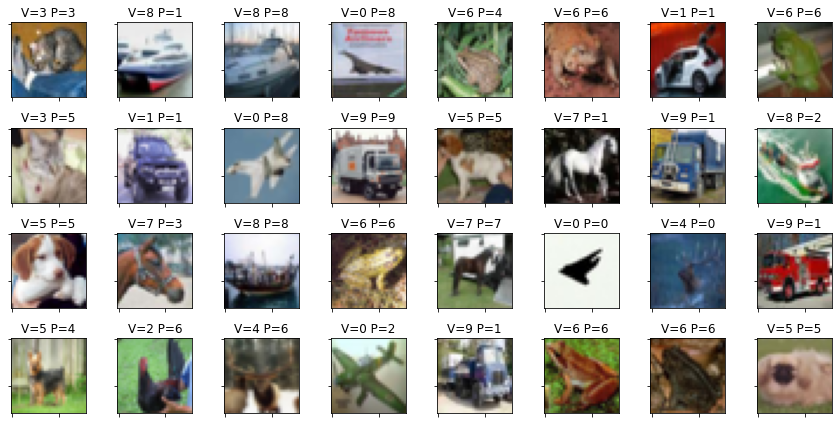


               precision    recall  f1-score   support

    airplane       0.50      0.25      0.33         4
  automobile       0.29      1.00      0.44         2
        bird       0.00      0.00      0.00         1
         cat       0.50      0.50      0.50         2
        deer       0.00      0.00      0.00         2
         dog       0.75      0.75      0.75         4
        frog       0.71      0.83      0.77         6
       horse       1.00      0.33      0.50         3
        ship       0.50      0.50      0.50         4
       truck       1.00      0.25      0.40         4

    accuracy                           0.50        32
   macro avg       0.53      0.44      0.42        32
weighted avg       0.62      0.50      0.50        32

F1-score: 0.5


In [ ]:
model1=CNN()
redConvolucional(model1,trn_dl, tst_dl,nombre="modelo1",epocas=20)

El modelo es incapaz de clasificar las imagenes de venedados, al ser tan sencilla la red es incapaz de capturar caracteristicas significativas.

## Modelo 2
Para este modelo se decidio usar batch normalizacion despues de cada capa convolucional y como funcion de activacion leaky relu.

In [ ]:
class CNN2(nn.Module):

    def __init__(self):
        super(CNN2, self).__init__()
        self.num_feats=16*16*32
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool2d(32),
            nn.Conv2d(in_channels=64, out_channels=32, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool2d(16)
        ) 
        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 10)

    # metodo para inferencia
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

Model:
CNN2(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AdaptiveMaxPool2d(output_size=32)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): AdaptiveMaxPool2d(output_size=16)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=8192, out_features=10, bias=True)
)


Summary:
Layer (type:depth-idx)                   Output Shape              Param #
CNN2                                     --                        --
├─Sequential: 1-1                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]    

E00 loss=[128.92,132.54] acc=[54.12,52.84]
E01 loss=[110.41,117.26] acc=[62.09,58.93]
E02 loss=[ 99.41,109.21] acc=[66.00,61.58]
E03 loss=[ 93.46,104.73] acc=[67.88,63.32]
E04 loss=[ 88.86,102.67] acc=[69.70,64.15]
E05 loss=[ 87.22,102.90] acc=[70.19,64.69]
E06 loss=[ 82.34, 99.06] acc=[72.15,65.69]
E07 loss=[ 79.50, 98.67] acc=[72.77,65.98]
E08 loss=[ 77.40, 97.75] acc=[73.26,66.42]
E09 loss=[ 74.11, 96.32] acc=[75.17,66.58]
E10 loss=[ 71.23, 94.82] acc=[75.90,67.37]
E11 loss=[ 72.43, 97.34] acc=[75.44,66.31]
E12 loss=[ 68.83, 95.91] acc=[76.65,67.06]
E13 loss=[ 67.75, 96.13] acc=[76.78,67.14]
E14 loss=[ 64.03, 93.74] acc=[78.61,68.08]
E15 loss=[ 63.81, 95.24] acc=[78.63,67.23]
E16 loss=[ 59.01, 91.65] acc=[80.54,68.69]
E17 loss=[ 62.17, 96.67] acc=[79.12,67.23]
E18 loss=[ 60.04, 95.28] acc=[79.79,68.03]
E19 loss=[ 59.87, 97.16] acc=[79.62,66.81]


Grafica de Perdida



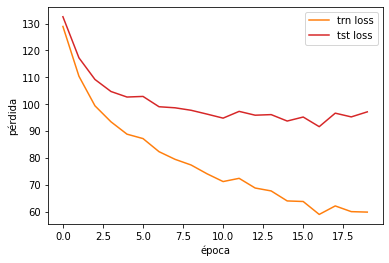


Grafica de Exactitud



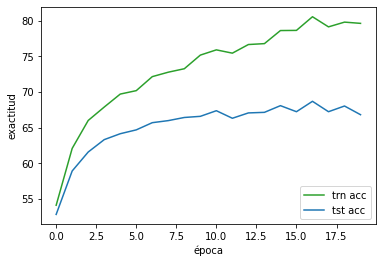

loss=[ 59.96, 97.16] acc=[79.44,66.81]

Evaluacion del Modelo:



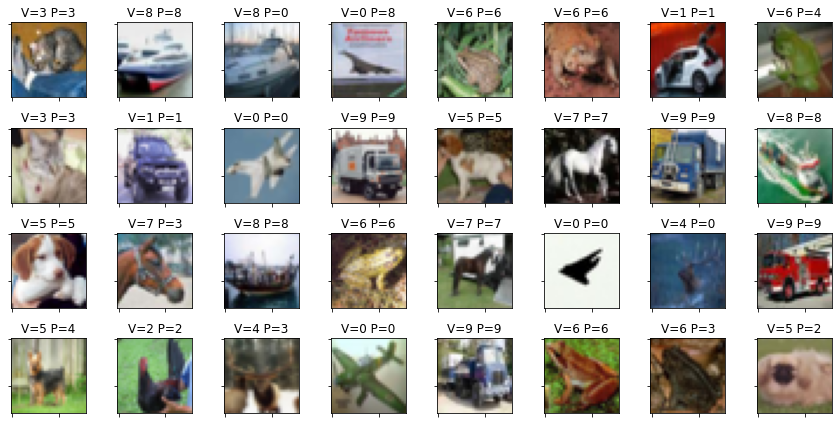


               precision    recall  f1-score   support

    airplane       0.60      0.75      0.67         4
  automobile       1.00      1.00      1.00         2
        bird       0.50      1.00      0.67         1
         cat       0.40      1.00      0.57         2
        deer       0.00      0.00      0.00         2
         dog       1.00      0.50      0.67         4
        frog       1.00      0.67      0.80         6
       horse       1.00      0.67      0.80         3
        ship       0.75      0.75      0.75         4
       truck       1.00      1.00      1.00         4

    accuracy                           0.72        32
   macro avg       0.72      0.73      0.69        32
weighted avg       0.80      0.72      0.73        32

F1-score: 0.73


In [ ]:
model2=CNN2()
redConvolucional(model2,trn_dl, tst_dl,epocas=20,nombre="modelo2")

Podemos observar una gran mejora en todas las clases con respecto al modelo mas sencillo y una mejora de mas 20% de F1-score. Este modelo tampoco es capaz de calsificar correctamente la clase venado.

## Modelo 3
Para este modelo se hizo uso de una red con 3 bloques residuales.

In [ ]:
class Bloque(nn.Module):
    def __init__(self, in_channels, 
                 out_channels1, out_channels2):
        super(Bloque, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, 
                      kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels1),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels2),
            nn.ReLU()
        )  
        self.b2=nn.Conv2d(in_channels=in_channels, out_channels=out_channels2, 
                      kernel_size=1, padding=0)    
    # metodo para inferencia
    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x)
        x=x1+x2
        x=F.relu(x)
        return x

In [ ]:
block = Bloque(in_channels=3, 
                       out_channels1=64,
                       out_channels2=32)
block

Bloque(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (b2): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
x = torch.zeros(1, 3, 32, 32)
y = block(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 32, 32, 32])


In [ ]:
summary(block, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Bloque                                   --                        --
├─Sequential: 1-1                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           18,464
│    └─BatchNorm2d: 2-5                  [1, 32, 32, 32]           64
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
├─Conv2d: 1-2                            [1, 32, 32, 32]           128
Total params: 20,576
Trainable params: 20,576
Non-trainable params: 0
Total mult-adds (M): 21.39
Input size (MB): 0.01
Forward/backward pass size (MB): 1.84
Params size (MB): 0.08
Estimated Total Size (MB): 1.93

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.num_feats=16*16*32
        self.cnn=nn.Sequential(
        Bloque(in_channels=3, 
                       out_channels1=64,
                       out_channels2=32),
        Bloque(in_channels=32, 
                out_channels1=64,
                out_channels2=32),
        nn.AdaptiveMaxPool2d(32),
        Bloque(in_channels=32, 
                       out_channels1=64,
                       out_channels2=32),  
        nn.AdaptiveMaxPool2d(16),                 
        )
        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 10)

      # metodo para inferencia
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

Model:
ResNet(
  (cnn): Sequential(
    (0): Bloque(
      (b1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (b2): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Bloque(
      (b1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (b2): Conv2d(32, 32, kerne

E00 loss=[128.05,131.85] acc=[54.17,52.59]
E01 loss=[104.06,111.55] acc=[63.13,59.98]
E02 loss=[ 90.85,100.30] acc=[68.28,64.02]
E03 loss=[ 86.57, 99.41] acc=[69.58,64.96]
E04 loss=[ 87.10,101.65] acc=[68.94,63.89]
E05 loss=[ 73.25, 91.57] acc=[74.55,67.76]
E06 loss=[ 64.78, 85.44] acc=[77.99,69.68]
E07 loss=[ 62.36, 85.12] acc=[78.73,70.17]
E08 loss=[ 58.35, 83.91] acc=[80.32,71.19]
E09 loss=[ 53.52, 81.78] acc=[82.24,71.61]
E10 loss=[ 51.08, 81.73] acc=[83.06,72.33]
E11 loss=[ 47.73, 81.01] acc=[84.56,71.87]
E12 loss=[ 48.73, 84.55] acc=[83.42,71.24]
E13 loss=[ 46.05, 84.26] acc=[84.27,70.92]
E14 loss=[ 42.78, 83.58] acc=[85.89,71.79]
E15 loss=[ 38.11, 80.94] acc=[88.20,72.30]
E16 loss=[ 35.25, 80.28] acc=[89.57,72.80]
E17 loss=[ 35.75, 84.02] acc=[88.70,71.76]
E18 loss=[ 31.11, 81.19] acc=[90.81,72.78]
E19 loss=[ 32.30, 83.85] acc=[89.96,72.01]


Grafica de Perdida



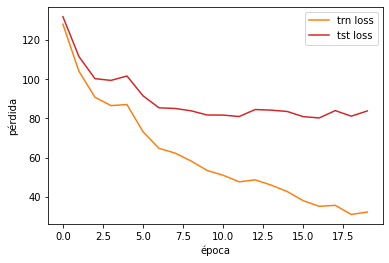


Grafica de Exactitud



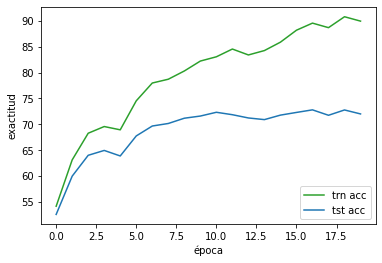

loss=[ 32.24, 83.85] acc=[90.11,72.01]

Evaluacion del Modelo:



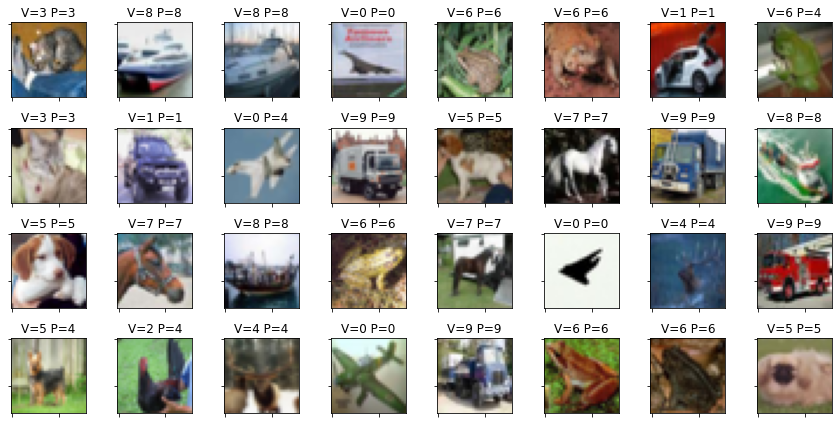


               precision    recall  f1-score   support

    airplane       1.00      0.75      0.86         4
  automobile       1.00      1.00      1.00         2
        bird       0.00      0.00      0.00         1
         cat       1.00      1.00      1.00         2
        deer       0.33      1.00      0.50         2
         dog       1.00      0.75      0.86         4
        frog       1.00      0.83      0.91         6
       horse       1.00      1.00      1.00         3
        ship       1.00      1.00      1.00         4
       truck       1.00      1.00      1.00         4

    accuracy                           0.88        32
   macro avg       0.83      0.83      0.81        32
weighted avg       0.93      0.88      0.88        32

F1-score: 0.88


In [ ]:
model3=ResNet()
redConvolucional(model3,trn_dl, tst_dl,epocas=20,nombre="modelo3")

A pesar de ser una red no muy profunda y de las pocas epocas de entrenamiento este modelo obtuvo una puntuacion perfecta para 5 de las 10 clases y un F1-score del 88% lo cual es una mejora significativa con respecto a los modelos anteriores aunque es incapaz de clasificar la clase ave y suele confundir a los perros y los gallos con venados.